In [144]:
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import hvplot.pandas
import requests_cache
from scipy.stats import linregress

# from datetime import datetime, timedelta
from retry_requests import retry

In [130]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [131]:
city_data_path = "../data/city_data.csv"
city_data = pd.read_csv(city_data_path)

In [132]:
# datetime.strftime(datetime.now() - timedelta(3), "%Y-%m-%d")

url = "https://archive-api.open-meteo.com/v1/archive"
res_list = []

city_index = 0
for city in city_data["city"]:
    params = {
        "latitude": city_data["lat"][city_index],
        "longitude": city_data["lon"][city_index],
        "start_date": "2022-01-01",
        "end_date": "2022-12-31",
        "hourly": "temperature_2m",
        "daily": "temperature_2m_mean",
        "temperature_unit": "fahrenheit",
        "timezone": "auto",
    }
    res_list.append(openmeteo.weather_api(url, params=params))
    city_index += 1

city_index = 0
data_list = []
for res in res_list:
    hourly = res[0].Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s"),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["temperature_2m"] = hourly_temperature_2m

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    daily = res[0].Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s"),
            end=pd.to_datetime(daily.TimeEnd(), unit="s"),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["city"] = city_data["city"][city_index]

    daily_dataframe = pd.DataFrame(data=daily_data)

    data_list.append(daily_dataframe)

    city_index += 1

data_con = pd.concat(data_list)

data_merge = data_con.merge(city_data, how="inner", on="city")

In [133]:
temperature_sum_by_city = data_merge.groupby("city")["temperature_2m_mean"].mean()

data_merge = city_data.merge(temperature_sum_by_city, how="right", on="city")

In [134]:
data_merge.to_csv("../data/weather_data.csv", index=False)

In [135]:
bins = [0, 32, 64, 90]
labels = ["0ºF-32ºF", "<32ºF-64ºF", "<64ºF-90ºF"]
data_merge["avg_temp_bin"] = pd.cut(
    data_merge["temperature_2m_mean"], bins, labels=labels
)

data_merge["avg_temp_bin"].value_counts()

avg_temp_bin
<32ºF-64ºF    68
<64ºF-90ºF    32
0ºF-32ºF       0
Name: count, dtype: int64

In [143]:
mean_temp_vs_crime_index = data_merge.hvplot(
    x="temperature_2m_mean", y="crime_index", kind="scatter"
)

mean_temp_vs_crime_index

:Scatter   [temperature_2m_mean]   (crime_index)

The r-squared is: 0.052154303446174645


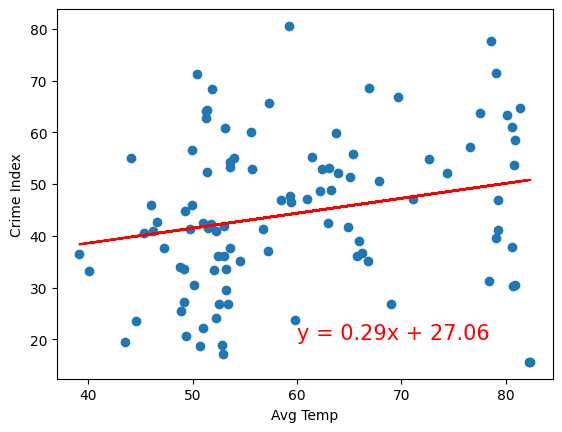

In [146]:
x_values = data_merge["temperature_2m_mean"]
y_values = data_merge["crime_index"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (60, 20), fontsize=15, color="red")
plt.xlabel("Avg Temp")
plt.ylabel("Crime Index")
print(f"The r-squared is: {rvalue**2}")
plt.show()